## Исследование параметров качества вина

**Входные переменные (на основе физико-химических тестов):**
1. фиксированная кислотность
2. летучая кислотность
3. лимонная кислота
4. остаточный сахар
5. хлориды
6. свободный диоксид серы
7. диоксид серы общий
8. плотность
9. рН
10. сульфаты
11. алкоголь
<br>Выходная переменная (на основе сенсорных данных):</br>
12. качество (оценка от 0 до 10) 

### 1. Подготовка датасета

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import requests,zipfile,io #работает с архивами
import matplotlib.pyplot as plt #работает с графиками и диаграммами
import seaborn as sns #работает с графиками и диаграммами
import numpy as np

Считываем датасет

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
df.sample(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
70,7.7,0.63,0.08,1.9,0.076,15.0,27.0,0.9967,3.32,0.54,9.5,6
683,8.1,0.78,0.23,2.6,0.059,5.0,15.0,0.9970,3.37,0.56,11.3,5


### 2. Создание новой переменной good на основе переменной quality с оценками вина

In [3]:
df['good']=df.quality.apply(lambda x:1 if x>5 else 0)

### 3. Исследование химических характеристик и их влияние на качество вина

Построим гистограмму распределения вина по качеству и посмотрим на его частоту.

Text(0.5, 1.0, 'Гистограмма распределения качества вина в баллах')

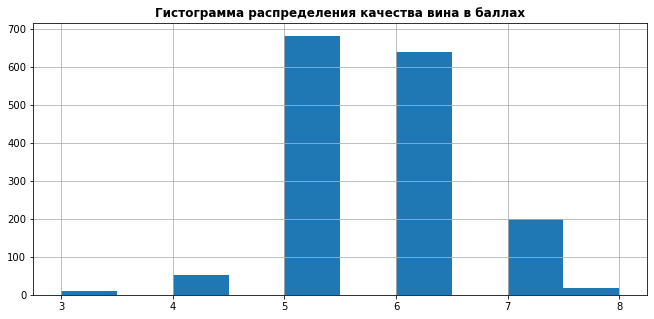

In [4]:
df["quality"].hist(figsize=(11,5),bins=10)
plt.title('Гистограмма распределения качества вина в баллах', fontweight ="bold")

Гистограмма распределения имеет признаки вероятностного распределения дискретного типа - распределение Пауссона, скошенное вправо, что говорит о преобладающем большинстве качества вина выше среднего. Самое распространенное - вино среднего качества. Вино самого высокого и низкого качества занимают незначительную долю, их меньше 5%.

Построим хитмэп по матрице корреляций

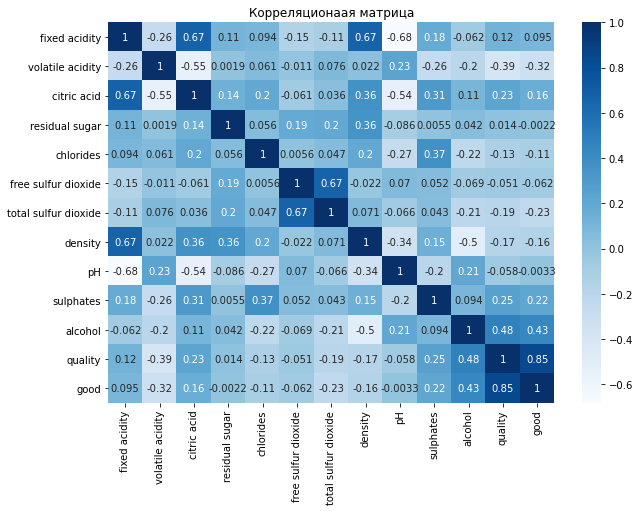

In [5]:
plt.figure(figsize = (10,7))
sns.heatmap(df.corr(), cmap = 'Blues', annot = True)
plt.title('Корреляционаая матрица')
plt.show()

Выделим ключевой параметр - quality. Рассмотрим коэффицент его корреляции по другим признакам, исключим корреляцию самим с собой и созданным параметром качества good.

Наибольшая корреляция по алкоголю, сульфатам и обратная корреляция по кислотности.

Рассмотрим все коррелируемые признаки на графике.

<AxesSubplot:title={'center':'График зависимости качества вина от его параметров'}>

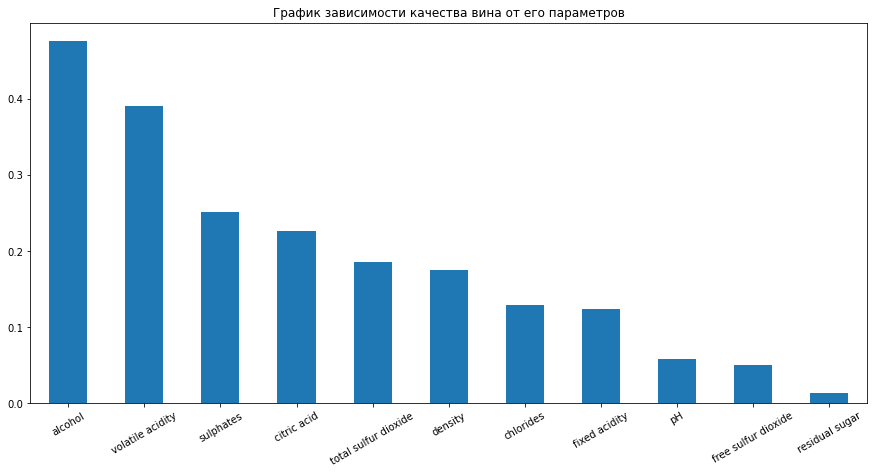

In [6]:
title="График зависимости качества вина от его параметров"
cor_param=df.corr().iloc[0:,-2].abs().sort_values(ascending=False).iloc[2:]
cor_param.plot(kind='bar',rot=30,figsize=(15,7),title=title)
#plt.bar.

Наибольшая корреляция по алкоголю и кислотности, меньше всего по диоксиду серы и сахару.

Посмотрим на количество имеющегося вина по градусу алкоголя и качеству. Для этого категоризируем показатель количества алкоголя и построим гистограмму.

In [7]:
df['alcohol_cat']=pd.cut(df["alcohol"], [8,10-.1,12-.1,13-.1,np.inf], labels=['8-9%','10-11%','12%','13-15%'])

<AxesSubplot:title={'center':'Распределение градусов алкоголя и качество вина'}>

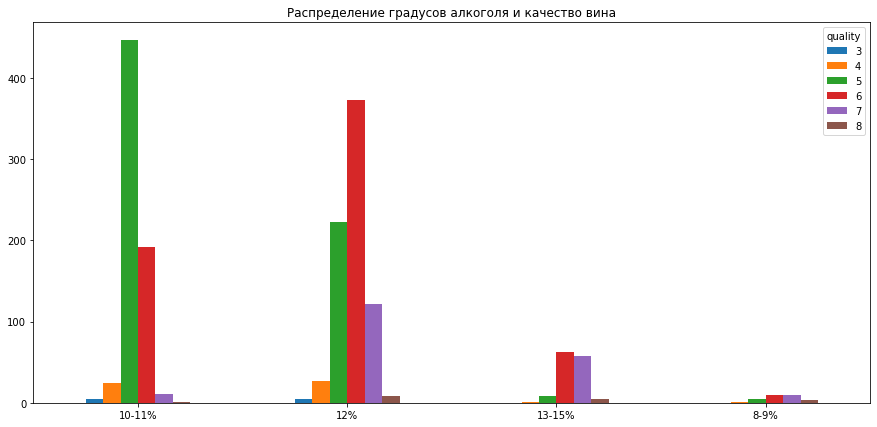

In [8]:
title='Распределение градусов алкоголя и качество вина'
sub=pd.pivot_table(df,
           index='quality',
           columns='alcohol_cat',
           aggfunc={'alcohol_cat':['count']}).reset_index()
sub.set_axis(['quality']+sorted(df.alcohol_cat.unique()), axis='columns', inplace=True)
sub.set_index('quality').T.plot(kind='bar',rot=0,figsize = (15,7),title=title)

Наибольше всего представлено вин на 10-13 градусов. Начиная с 10 градусов наблюдается положительная кореляция с качеством и заметен тренд на его повышение.

Но тем не менее данные расчеты являются малоинформативными, т.к. общее количество вин может не равномерно варьироваться по совокупности признаков. Расчитаем процентное соотношение качества вина к общему количеству представлнному по категориям алкоголя.

<AxesSubplot:title={'center':'Процент качества вина в выборке по алкоголю'}>

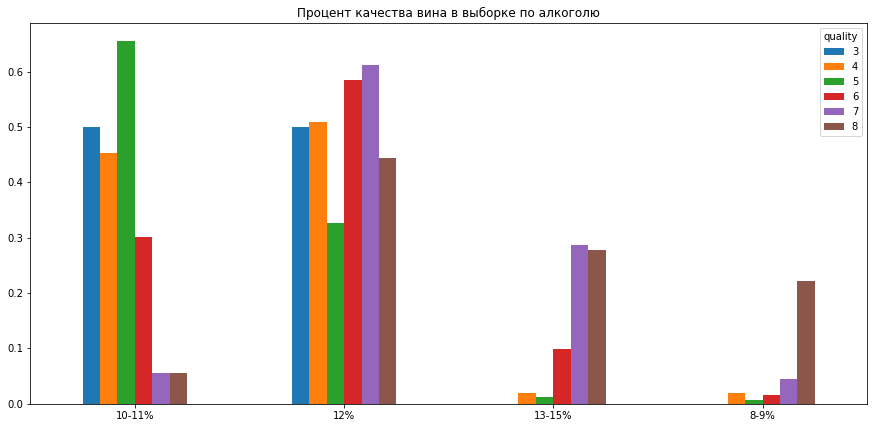

In [9]:
sub.set_index('quality')
sub['sum']=sub.iloc[:,1:].apply(sum,axis=1)
sub2=sub.iloc[:,1:-1].T.div(list(sub['sum']))
sub2.columns=sub['quality']
title='Процент качества вина в выборке по алкоголю'
sub2.plot(kind='bar',rot=0,figsize = (15,7),title=title)

В получиышихся гистограммах также наблюдается тренд на воышение качества с увеличением градусов алкоголя. Вина с 10-11 градусами имеют наименьшее соотношение по высокому качеству вина, а 13-15 и 8-9 наибольшее.

Построим круговую диаграмму распределения градусов алкоголя.

<Figure size 432x288 with 0 Axes>

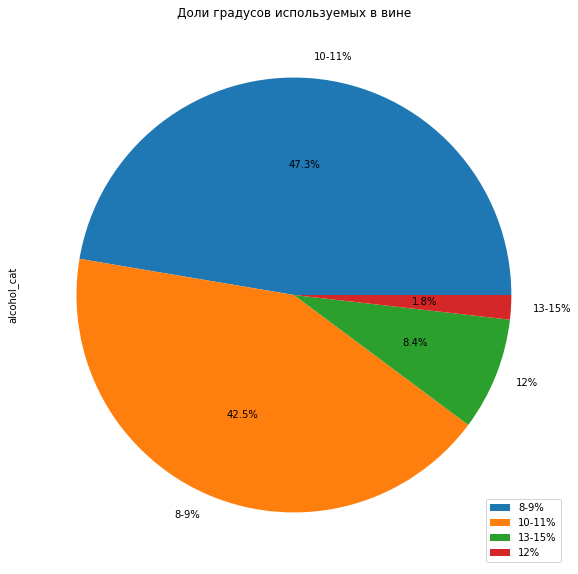

In [10]:
plt.figure()
pd.DataFrame(df['alcohol_cat'].value_counts()).plot(kind="pie", autopct='%1.1f%%', subplots=True,figsize = (10,10))
plt.title('Доли градусов используемых в вине')
plt.legend([i for i in list(df['alcohol_cat'].unique())])
plt.show()

Посмотрим второй коррелируемый признак - кислотность(volatile acidity). Для этого используем диаграмму рассеяния. 

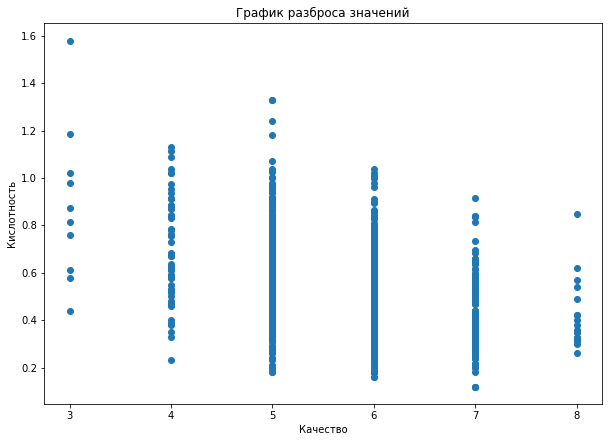

In [11]:
plt.figure(figsize = (10,7))
plt.scatter(df['quality'], df['volatile acidity'])
plt.title('График разброса значений')
plt.ylabel('Кислотность')
plt.xlabel('Качество')
plt.show()

На графике прослеживается заметная обратная корреляция - верхняя граница распределения уменьшается с увеличением качества вина.  

Рассмотрим распределения кислотности для вин высокого и низкого качества.

Text(0, 0.5, 'volatile acidity')

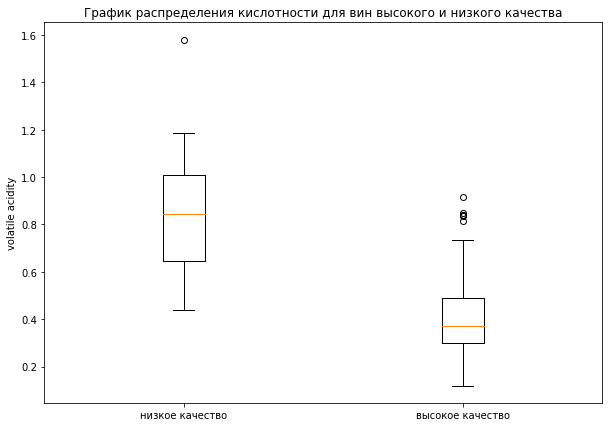

In [12]:
plt.figure(figsize = (10,7))
plt.boxplot([df.loc[df['quality']<4,'volatile acidity'],df.loc[df['quality']>6,'volatile acidity']])
plt.title('График распределения кислотности для вин высокого и низкого качества')
plt.xticks([1, 2],['низкое качество', 'высокое качество'])
plt.ylabel('volatile acidity')

Из графика видно, что межквартильный размах для вин высокого качества находится в диапазоне от 0.3 до 0.5, а низкого качества от 0.7 до 1.

Таким образом значение кислотности для вин высокого качества должно находится ниже верхнего квартиля - 0.5. Проверим наше наблюдение и выведем точное значение Q3. 

In [13]:
df.loc[df['quality']>6,'volatile acidity'].quantile(.75)

0.49

Посмотрим влияние еще трех признаков - 'sulphates','citric acid' и 'total sulfur dioxide'.

Построим диграмму рассеяния - pairplot.

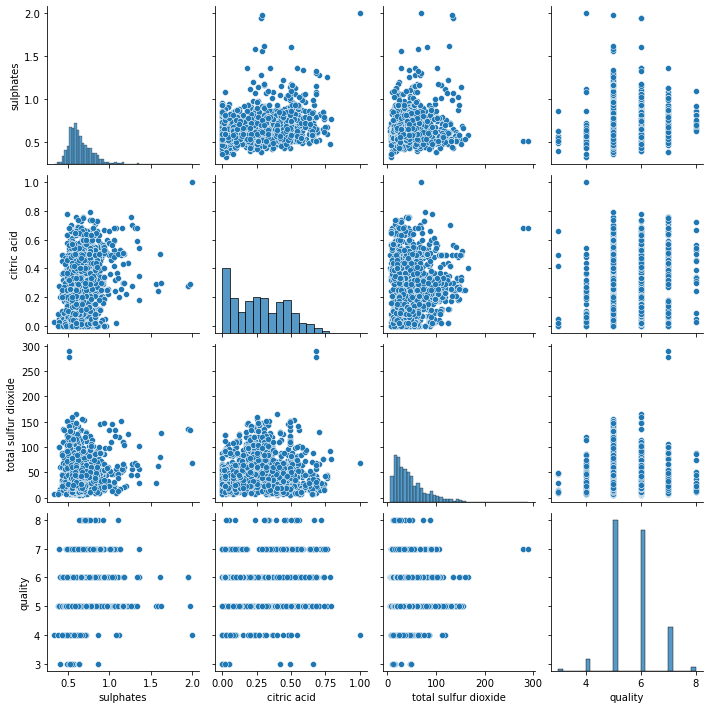

In [14]:
sns.pairplot(df[['sulphates','citric acid','total sulfur dioxide','quality']])

Как видно из графиков эти параметры имеют положительную но не ярко выраженную корреляцию и как следствие не оказывают существенное влияние на качество вина.

**Вывод:** 
1. На качество вина влияют все представленные признаки. Но наибольшее влияние оказывает алкоголь и кислотность.
2. Самая большая вероятность получить вино высокого качества если оно имеет градус 13-15 и кислотность 0.3-0.5.